In this notebook, I will investigate the degree of missingness. First on the X, and then the autosomes.

In [2]:
%run ../scripts/notebook_settings.py

In [3]:
meta_data_samples = pd.read_excel("../data/New_Papio.xlsx")
vcf_dir = "/faststorage/project/primatediversity/data/PG_baboons_pananu3_23_2_2021/"
vcf_names = "output.filtered.snps.{}.removed.AB.pass.vep.vcf.gz"
vcf_path = vcf_dir+vcf_names
meta_data_samples = meta_data_samples.loc[meta_data_samples.Origin != "captive"] #Removing captive individual
vcf_callset = allel.read_vcf(vcf_path.format("chrX"), samples=meta_data_samples["PGDP_ID"].tolist())

Code burrowed from Kasper the make the callset_indexes.

In [3]:
samples_list = list(vcf_callset['samples'][:])
samples_callset_index = [samples_list.index(s) for s in meta_data_samples.PGDP_ID]
meta_data_samples['callset_index'] = samples_callset_index
meta_data_samples

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,callset_index
1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,0
2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,1
3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,2
4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,3
5,PD_0203,21SNF1151115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,4
...,...,...,...,...,...,...,...,...
213,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,212
214,PD_0791,34419_BZ11066,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,213
215,PD_0792,34420_BZ11067,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,214
216,PD_0793,34422_BZ11070,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",M,215


Creating the gt dataframe

In [4]:
gt = allel.GenotypeArray(vcf_callset["calldata/GT"])
n_s = len(vcf_callset["samples"]) #number of samples

Calculating and plotting missingness

In [5]:
missingness = gt.is_missing()

In [6]:
m_per_s = missingness.sum(axis=1)

In [7]:
d = {"m": m_per_s, "pos": vcf_callset["variants/POS"]}
m_df = pd.DataFrame(data=d)

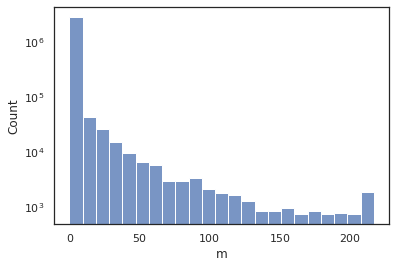

In [8]:
g = sns.histplot(m_df, x="m")
g.set_yscale("log")

In [22]:
len(m_df.loc[m_df.m == n_s]) #99 sites with no calls, comes from the captive/old individuals
len(m_df.loc[m_df.m == 0]) #2572788 sites with no missing
len(m_df.loc[m_df.m == 0])/len(m_df) #0.880 of sites has no missing
len(m_df.loc[m_df.m <= n_s*0.1])/len(m_df) #0.973 of sites has less than 10 % missing
len(m_df.loc[m_df.m <= n_s*0.2])/len(m_df) #0.986 of sites has less than 20 % missing

0.9864005758049706

Same analysis, now on chr7

In [4]:
vcf_callset = allel.read_vcf(vcf_path.format("chr7"), samples=meta_data_samples["PGDP_ID"].tolist())
gt = allel.GenotypeArray(vcf_callset["calldata/GT"])
n_s = len(vcf_callset["samples"]) #number of samples
missingness = gt.is_missing()
m_per_s = missingness.sum(axis=1)
d = {"m": m_per_s, "pos": vcf_callset["variants/POS"]}
m_chr7_df = pd.DataFrame(data=d)

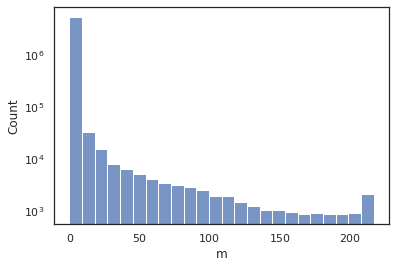

In [5]:
g = sns.histplot(m_chr7_df, x="m")
g.set_yscale("log")

Repeating X analysis based on zarr, and with the newer metadata generated in dp01

In [14]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_01_03_2021/callset.zarr/chrX"
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode='r')
gt = allel.GenotypeArray(callset["calldata/GT"])

In [8]:
n_s = len(callset["samples"]) #number of samples
missingness = gt.is_missing()
m_per_s = missingness.sum(axis=1)
d = {"m": m_per_s, "pos": callset["variants/POS"]}
m_zarr_df = pd.DataFrame(data=d)

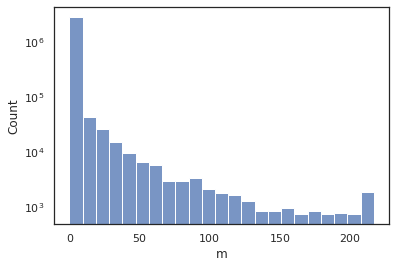

In [9]:
g = sns.histplot(m_zarr_df, x="m")
g.set_yscale("log")

In [11]:
len(m_zarr_df.loc[m_zarr_df.m <= n_s*0.1])/len(m_zarr_df) #0.973 again
len(m_zarr_df.loc[m_zarr_df.m <= n_s*0.05])/len(m_zarr_df) #0.958

0.9580468334147506

Now only with females and less than 10 % missing
I notice now that I misread dp02 by a factor of 10 - the highest degree of missingness is 1,6 %, not 16 %

In [33]:
females = meta_data_samples.loc[(meta_data_samples.Sex == "F")]
max(females["x_missing"]), len(females)

(0.016083677817414543, 95)

In [30]:
IDs = (meta_data_samples.loc[(meta_data_samples.x_missing <= 0.05)
                             & (meta_data_samples.Sex == "F")]).callset_index.values
len(IDs)

95

In [44]:
gt_females = gt.take(IDs, axis=1)

In [48]:
n_s = len(IDs) #number of samples
missingness = gt_females.is_missing()
m_per_s = missingness.sum(axis=1)
d = {"m": m_per_s, "pos": callset["variants/POS"]}
m_zarr_f_df = pd.DataFrame(data=d)

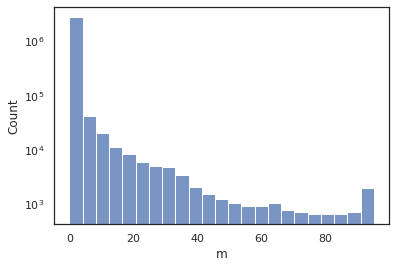

In [49]:
g = sns.histplot(m_zarr_f_df, x="m")
g.set_yscale("log")

In [52]:
len(m_zarr_f_df.loc[m_zarr_f_df.m <= n_s*0.1])/len(m_zarr_df) #0.976 again
len(m_zarr_f_df.loc[m_zarr_f_df.m <= n_s*0.05])/len(m_zarr_df) #0.96

0.9605232189796703

Picking out the sites to keep:
sites = 